In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import unittest

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Custom residual block 
This code is based on the Tensorflow [tutorial](https://www.tensorflow.org/tutorials/customization/custom_layers).

In [9]:
class ResBlock(tf.keras.Model):
  """ A ResBlock module class with expansion, depthwise consolution and 
  projection.

  In this ResBlock, standard 2D convolutions are replaced by 1x1 convolution 
  that expands the input tensor along the channel dimension, depthwise
  convolution and 1x1 convolution that projects the tensor back to the original
  number of channels.

   Args: 
     kernel_size: size of the depthwise convolution kernel
     expansion_factor: expansion factor of the first 1x1 convolution. 
     e.g., if the input tensor has N channels, then the first 1x1 
     convolution layer will expand it to expansion_factor*N channels.
     activation: activation function. Supported functions: 'relu',
     'relu6', 'lrelu', 'swish'."""

  def __init__(self, kernel_size=3, expansion_factor=6, activation='relu'):
    super(ResBlock, self).__init__(name='')
    if expansion_factor < 1:
      raise ValueError('The expansion factor value should be '
      'greater than or equal to one.')

    self.expansion_factor = expansion_factor
    self.activation = self.set_activation_fn(activation)
    self.kernel_size = kernel_size

  def build(self, input_shape):
    input_channel = input_shape[-1]
    self.expanded_channel = input_channel*self.expansion_factor
    self.conv1 = tf.keras.layers.Conv2D(self.expanded_channel, kernel_size=1,
                                        strides=(1, 1), padding='same')
    self.bn1 = tf.keras.layers.BatchNormalization() 
    self.conv2 = tf.keras.layers.DepthwiseConv2D(kernel_size=self.kernel_size,
                                                 strides=(1, 1), padding='same')
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.conv3 = tf.keras.layers.Conv2D(input_channel, kernel_size=1,
                                        strides=(1, 1), padding='same')
    self.bn3 = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training=True):
    x = self.conv1(input_tensor)
    x = self.bn1(x, training=training)
    x = self.activation(x)

    x = self.conv2(x)
    x = self.bn2(x, training=training)
    x = self.activation(x)

    x = self.conv3(x)
    x = self.bn3(x, training=training)
    x += input_tensor
    return x

  def set_activation_fn(self, activation):
    switcher = {'relu': tf.nn.relu,
                'relu6': tf.nn.relu6,
                'lrelu': tf.nn.leaky_relu,
                'swish': tf.nn.swish}
    
    res = switcher.get(activation)
    if not res:
      raise Exception("Given activation function is not supported.")
    return res

  def _get_input_channel(self, input_shape):
    if input_shape.dims[-1].value is None:
      raise ValueError('The channel dimension of the inputs '
                       'should be defined. Found `None`.')
    return int(input_shape[-1])


# Testing

In [14]:
class BlockTest(tf.test.TestCase):
  def setUp(self):
    super(BlockTest, self).setUp()

  def _run_standard_block(self, input_tensor):
    block = ResBlock(kernel_size=3, expansion_factor=6, activation='relu')
    block.build(tf.shape(input_tensor))
    return block(input_tensor)
    
  def test_basic(self):
    """Checking if the input and output tensors shapes match."""
    input_shape = (32, 128, 128, 64)
    input_val = tf.random.normal([*input_shape])
    out = self._run_standard_block(input_val)
    self.assertShapeEqual(input_val.numpy(), out)

  def test_standard_input(self):
    """Checking that input / output shapes match on input (8, 16, 16, 40)."""
    input_shape = (8, 16, 16, 40)
    input_val = tf.random.normal([*input_shape])
    out = self._run_standard_block(input_val)
    self.assertShapeEqual(input_val.numpy(), out)

  def test_expansion_wrong_val(self):
    with self.assertRaises(ValueError):
      block = ResBlock(kernel_size=3, expansion_factor=0, activation='relu')
    

  def test_zeros_input(self):
    input_shape = (8, 16, 16, 40)
    input_val = tf.zeros([*input_shape])
    out = self._run_standard_block(input_val)
    self.assertAllEqual(input_val, out)
  
  def test_wrong_activation(self):
    with self.assertRaises(Exception):
      block = ResBlock(kernel_size=3, expansion_factor=6, activation='sigmoid')
    

In [15]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

..s...
----------------------------------------------------------------------
Ran 6 tests in 0.352s

OK (skipped=1)


# Preparing the data


In [16]:
h, w, c = (32, 32, 3)
BATCH_SIZE = 64

In [17]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [18]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                  .batch(BATCH_SIZE, drop_remainder=True)
                  .shuffle(buffer_size=50000)).repeat()
test_dataset = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                  .batch(BATCH_SIZE, drop_remainder=True)).repeat()

for image, label in test_dataset.take(1):
    print(image.shape, label.shape)

(64, 32, 32, 3) (64, 1)


In [19]:
def normalize(x, y):
  x = tf.image.per_image_standardization(x)
  return x, y

def augment(x, y):
    x = tf.image.resize_with_crop_or_pad(x, h + 8, w + 8)
    x = tf.image.random_crop(x, [BATCH_SIZE, h, w, c])
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, max_delta=0.5)
    return x, y


test_dataset = test_dataset.map(normalize)
train_dataset = (train_dataset
                 .map(augment)
                 .map(normalize))

# Creating and training the model

In [20]:
num_res_blocks = 10

In [21]:
inputs = keras.Input(shape=(h, w, c))
x = layers.Conv2D(64, 7, activation='swish')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

for i in range(num_res_blocks):
    x = ResBlock(kernel_size=3, 
                 expansion_factor=6,
                 activation='swish')(x)
x = layers.Conv2D(64, 3, activation='swish')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='swish')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 64)        9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
res_block_1 (ResBlock)       (None, 13, 13, 64)        56768     
_________________________________________________________________
res_block_2 (ResBlock)       (None, 13, 13, 64)        56768     
_________________________________________________________________
res_block_3 (ResBlock)       (None, 13, 13, 64)        56768     
_________________________________________________________________
res_block_4 (ResBlock)       (None, 13, 13, 64)        56768 

In [23]:
callbacks = [
  (keras.callbacks.TensorBoard(log_dir='./log/{}'
                              .format(dt.datetime.now()
                              .strftime("%Y-%m-%d-%H-%M-%S")),
                               write_images=True)),
]
model.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
history = model.fit(train_dataset, epochs=30,
                    steps_per_epoch=195,
                    validation_data=test_dataset,
                    validation_steps=3,
                    callbacks=callbacks)

Epoch 1/30
195/195 [==============================] - 17s 88ms/step - loss: 2.3365 - acc: 0.2870 - val_loss: 2.0523 - val_acc: 0.2760
Epoch 2/30
195/195 [==============================] - 17s 85ms/step - loss: 1.6806 - acc: 0.3799 - val_loss: 1.8066 - val_acc: 0.3073
Epoch 3/30
195/195 [==============================] - 17s 85ms/step - loss: 1.5766 - acc: 0.4269 - val_loss: 1.5614 - val_acc: 0.3854
Epoch 4/30
195/195 [==============================] - 17s 86ms/step - loss: 1.5080 - acc: 0.4560 - val_loss: 1.4236 - val_acc: 0.4635
Epoch 5/30
195/195 [==============================] - 17s 87ms/step - loss: 1.4572 - acc: 0.4720 - val_loss: 1.5269 - val_acc: 0.4375
Epoch 6/30
195/195 [==============================] - 17s 87ms/step - loss: 1.4296 - acc: 0.4776 - val_loss: 1.5805 - val_acc: 0.4375
Epoch 7/30
195/195 [==============================] - 17s 88ms/step - loss: 1.3733 - acc: 0.5053 - val_loss: 1.3848 - val_acc: 0.4688
Epoch 8/30
195/195 [==============================] - 17s 88ms

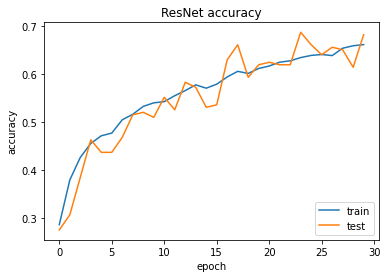

In [24]:
#Plotting the accuracy during training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('ResNet accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [25]:
results = model.evaluate(test_dataset, steps=5000)
print('test loss, test acc:', results)

5000/5000 [==============================] - 129s 26ms/step - loss: 1.0110 - acc: 0.6446
test loss, test acc: [1.0109683275222778, 0.6446343660354614]
